In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import h3
import folium
import matplotlib.pyplot as plt
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon, MultiPolygon
from branca.colormap import linear


Подгрузим границы центральных районов Казани. Преобразуем их в GeoDataFrame. Убедимся, что ничего не перепутано.

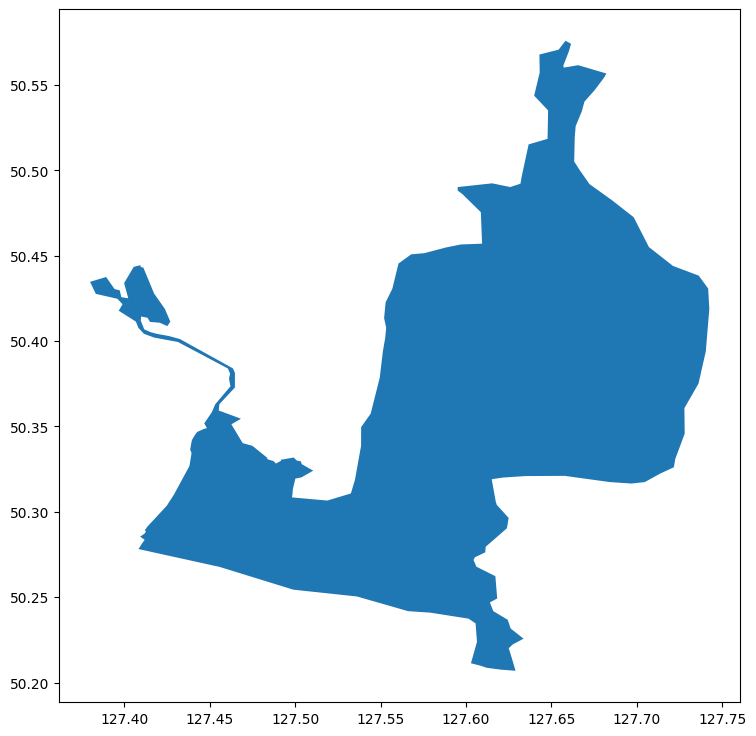

,name,poly
0,Благовещенск,"POLYGON ((127.74192 50.41180, 127.74045 50.394..."


In [2]:
city_name = 'Благовещенск'
with open('auth_borders/admin_level_6.geojson', encoding = 'utf-8') as f:
    a = json.load(f)
    for it in a['features']:
        if it['name'] == 'городской округ Благовещенск':
            city_gjs = it
            break
city_poly = Polygon(city_gjs['geometry']['coordinates'][0][0])
city_borders_gdf = gpd.GeoDataFrame({"name": [city_name], "poly": [city_poly]}, geometry = 'poly')
# a['features'][0]["name"]
city_borders_gdf.plot(figsize=(9, 9))
plt.show()
city_borders_gdf

Подгрузим статистику транзакций. Из нее тоже соберем геодатафрейм.

In [3]:
transactions_df = pd.read_excel("data/transactions/Blagoveschensk_TRs.xlsx")
transactions_gdf = gpd.GeoDataFrame(transactions_df, geometry = gpd.points_from_xy(transactions_df['longitude'], transactions_df['latitude']))


Далее посмотрим на получившиеся границы Города.

In [4]:
def get_lat_lon(geometry):
        
    lon = geometry.apply(lambda x: x.x if x.geom_type == 'Point' else x.centroid.x)
    lat = geometry.apply(lambda x: x.y if x.geom_type == 'Point' else x.centroid.y)
    # print(lon)
    # print(lat)
    # print("Geometry centroid:", sum(lat)/len(lat), sum(lon)/len(lon))
    return lat, lon
    
def visualize_polygons(geometry):
    
    lats, lons = get_lat_lon(geometry)
    
    m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=11, tiles='cartodbpositron')
    
    overlay = gpd.GeoSeries(geometry).to_json()
    folium.GeoJson(overlay, name = 'boundary').add_to(m)
    
    return m

visualize_polygons(city_borders_gdf['poly'])

In [5]:
def create_hexagons(geoJson):
    polyline = geoJson['coordinates'][0]

    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color="green")
    m.add_child(my_PolyLine)

    hexagons = list(h3.polyfill(geoJson, 8))
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=3,color='red')
        m.add_child(my_PolyLine)
        
    polylines_x = []
    for j in range(len(polylines)):
        a = np.column_stack((np.array(polylines[j])[:,1],np.array(polylines[j])[:,0])).tolist()
        polylines_x.append([(a[i][0], a[i][1]) for i in range(len(a))])
        
    polygons_hex = pd.Series(polylines_x).apply(lambda x: Polygon(x))
        
    return m, polygons_hex, polylines
# polygon_hex , polylines - геометрии гексагонов в разных форматах

Сформируем GeoJason из геометрии границ. Затем свопнем координаты местами (3 строчка). Несложными манипуляциями замостим Казань шестиугольниками. Сохраним их в разных форматах.

In [6]:
# сгенерируем гексагоны внутри полигона г. Казань
geoJson = json.loads(gpd.GeoSeries(city_borders_gdf['poly']).to_json())
geoJson = geoJson['features'][0]['geometry']
aaaaaa = np.array(geoJson['coordinates'][0])[:, 1]
geoJson = {'type':'Polygon','coordinates': [np.column_stack((np.array(geoJson['coordinates'][0])[:, 1],
                                                      np.array(geoJson['coordinates'][0])[:, 0])).tolist()]}
m, hexagons, polylines_hex = create_hexagons(geoJson)
m

Соберем всё вместе в один DataFrame. На данный момент у нас имеется pandas.Series гексагонов и обычный список их координат.

In [7]:
hexagons_df = pd.DataFrame(hexagons, columns = ['geometry'])
hexagons_df['polylines'] = polylines_hex
hexagons_df

,geometry,polylines
0,POLYGON ((127.54657703971208 50.32217350772367...,"[(50.322173507723676, 127.54657703971208), (50..."
1,POLYGON ((127.70165780830108 50.35544128417333...,"[(50.35544128417333, 127.70165780830108), (50...."
2,POLYGON ((127.56909789632165 50.29206222319499...,"[(50.292062223194996, 127.56909789632165), (50..."
3,POLYGON ((127.56909789632165 50.29206222319499...,"[(50.292062223194996, 127.56909789632165), (50..."
4,"POLYGON ((127.4847011533011 50.30119601116415,...","[(50.30119601116415, 127.4847011533011), (50.3..."
...,...,...
549,POLYGON ((127.46115783645301 50.35809224476649...,"[(50.35809224476649, 127.46115783645301), (50...."
550,POLYGON ((127.67337170167778 50.40940701576468...,"[(50.40940701576468, 127.67337170167778), (50...."
551,POLYGON ((127.68861360586673 50.38034381515329...,"[(50.38034381515329, 127.68861360586673), (50...."
552,POLYGON ((127.68130977638154 50.41963209012364...,"[(50.41963209012364, 127.68130977638154), (50...."


In [8]:
type(hexagons_df['geometry'])

pandas.core.series.Series

 Здесь избавимся от возможных дубликатов, добавим нумерацию и объединим гексагоны с записями о транзакциях

In [9]:
def clear_duplicates(data_df):
    data_df['geometry'] = data_df['geometry'].astype(str)
    data_df_uniq = pd.DataFrame(data_df['geometry'].drop_duplicates())
    data_df_uniq['id'] = np.arange(len(data_df_uniq)).astype(str)
    data_df = hexagons_df.merge(data_df_uniq, on = 'geometry')
    data_df['geometry'] = data_df['geometry'].apply(wkt.loads)
    data_df = data_df.dropna()
    data_gdf = gpd.GeoDataFrame(data_df, geometry='geometry')
    return data_gdf
####################################

hexagons_df['geometry'] = hexagons_df['geometry'].astype(str)
# - кастим тип, чтобы можно было сравнивать координаты затем обратно скастим с помощью wkt.loads()

hexagons_df_uniq = pd.DataFrame(hexagons_df['geometry'].drop_duplicates())
hexagons_df_uniq['id'] = np.arange(len(hexagons_df_uniq)).astype(str)
hexagons_df = hexagons_df.merge(hexagons_df_uniq, on = 'geometry')
hexagons_df['geometry'] = hexagons_df['geometry'].apply(wkt.loads)
hexagons_gdf = gpd.GeoDataFrame(hexagons_df, geometry='geometry')

cup_hex_gdf = gpd.sjoin(hexagons_gdf, transactions_gdf, how='left', op='intersects')
cup_hex_gdf = cup_hex_gdf.dropna()
print(type(cup_hex_gdf))
cup_hex_gdf.head()
cup_hex_gdf.tail()



<class 'geopandas.geodataframe.GeoDataFrame'>


/home/artee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,geometry,polylines,id,index_right,latitude,longitude,city,transactions
526,"POLYGON ((127.52103 50.25759, 127.52606 50.260...","[(50.25758501723957, 127.52103469287623), (50....",526,401.0,50.2648,127.5220,Благовещенск,100.0
534,"POLYGON ((127.55030 50.30256, 127.55248 50.298...","[(50.302564312143645, 127.55029701538653), (50...",534,331.0,50.3023,127.5563,Благовещенск,100.0
534,"POLYGON ((127.55030 50.30256, 127.55248 50.298...","[(50.302564312143645, 127.55029701538653), (50...",534,586.0,50.3052,127.5572,Благовещенск,50.0
535,"POLYGON ((127.50443 50.26393, 127.50224 50.268...","[(50.26393421187488, 127.50442978559302), (50....",535,177.0,50.2625,127.4924,Благовещенск,300.0
535,"POLYGON ((127.50443 50.26393, 127.50224 50.268...","[(50.26393421187488, 127.50442978559302), (50....",535,330.0,50.2650,127.4926,Благовещенск,100.0


In [10]:
cup_hex_gdf.head()


,geometry,polylines,id,index_right,latitude,longitude,city,transactions
2,"POLYGON ((127.56910 50.29206, 127.57413 50.295...","[(50.292062223194996, 127.56909789632165), (50...",2,443.0,50.2932,127.5653,Благовещенск,100.0
2,"POLYGON ((127.56910 50.29206, 127.57413 50.295...","[(50.292062223194996, 127.56909789632165), (50...",2,490.0,50.2963,127.5660,Благовещенск,90.0
9,"POLYGON ((127.56711 50.25812, 127.57214 50.261...","[(50.25811573783498, 127.56711426353671), (50....",9,966.0,50.2592,127.5659,Благовещенск,0.0
9,"POLYGON ((127.56711 50.25812, 127.57214 50.261...","[(50.25811573783498, 127.56711426353671), (50....",9,178.0,50.2592,127.5666,Благовещенск,300.0
9,"POLYGON ((127.56711 50.25812, 127.57214 50.261...","[(50.25811573783498, 127.56711426353671), (50....",9,104.0,50.2606,127.5596,Благовещенск,500.0


In [11]:
# подготовим данные 
cup_hex_gdf['geometry'] = cup_hex_gdf['geometry'].astype(str) #для groupby
cup_hex_gdf['id'] = cup_hex_gdf['id'].astype(str) #для Choropleth
agg_all = cup_hex_gdf.groupby(['geometry','id'], as_index = False).sum()
agg_all['geometry'] = agg_all['geometry'].apply(wkt.loads) #возвращаем формат геометрий
#agg_all
agg_all_cnts = agg_all[["geometry",'id', 'polylines', 'transactions']]
#agg_all_cnts
agg_all_cnts.loc[:, 'id'] = agg_all_cnts.loc[:, 'id'].astype(str)
data_geo_1 = gpd.GeoSeries(agg_all_cnts.set_index('id')["geometry"]).to_json()

#create_choropleth(agg_all_cnts, data_geo_1, ["id","cnt_transactions"], 'transaction counts', 'counts', 5)

/tmp/ipykernel_42393/3113194607.py:2: UserWarning: Geometry column does not contain geometry.
  cup_hex_gdf['geometry'] = cup_hex_gdf['geometry'].astype(str) #для groupby


In [12]:
def create_choropleth(data, json, columns, legend_name, feature, bins):
    
    lat, lon = get_lat_lon(data['geometry'])

    m = folium.Map(location=[sum(lat)/len(lat), sum(lon)/len(lon)], zoom_start=11, tiles='cartodbpositron')
    
    folium.Choropleth(
        geo_data=json,
        name="choropleth",
        data=data,
        columns=columns,
        key_on="feature.id",
        fill_color="Purples",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
        nan_fill_color = 'black',
        # marker=folium.Circle(radius=4, fill_color="orange", fill_opacity=0.4, color="black", weight=1),
        # tooltip=folium.GeoJsonTooltip(fields=["latitude", "longitude", "cnt_transactions"]),
        # popup=folium.GeoJsonPopup(fields=["latitude", "longitude", "cnt_transactions"]),
        bins = bins,
        #highlight=True,
    ).add_to(m)

    #folium.LayerControl().add_to(m)

    return m

m_polygons = create_choropleth(agg_all_cnts, data_geo_1, ["id","transactions"], 'transaction counts', 'counts', 7)
m_polygons

In [13]:
ATMs_df = pd.read_excel("data/ATMs/Blagoveschensk_ATMs.xlsx")
ATMs_gdf = gpd.GeoDataFrame(ATMs_df, geometry = gpd.points_from_xy(ATMs_df['longitude'], ATMs_df['latitude']), crs='EPSG:4326')
ATMs_gdf

,latitude,longitude,city,geometry
0,50.308612,127.565633,Благовещенск,POINT (127.56563 50.30861)
1,50.286562,127.523371,Благовещенск,POINT (127.52337 50.28656)
2,50.266297,127.568663,Благовещенск,POINT (127.56866 50.26630)
3,50.280930,127.554339,Благовещенск,POINT (127.55434 50.28093)
4,50.297903,127.506027,Благовещенск,POINT (127.50603 50.29790)
5,50.292708,127.530075,Благовещенск,POINT (127.53007 50.29271)
6,50.255889,127.555525,Благовещенск,POINT (127.55553 50.25589)
7,55.053736,55.957881,Благовещенск,POINT (55.95788 55.05374)
8,50.295496,127.558105,Благовещенск,POINT (127.55810 50.29550)
9,50.280281,127.510238,Благовещенск,POINT (127.51024 50.28028)


In [14]:
ATMs_gdf = ATMs_gdf.sjoin(city_borders_gdf, how="left", predicate='intersects')
ATMs_gdf = ATMs_gdf.dropna()
ATMs_gdf

/home/artee/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


,latitude,longitude,city,geometry,index_right,name
0,50.308612,127.565633,Благовещенск,POINT (127.56563 50.30861),0.0,Благовещенск
1,50.286562,127.523371,Благовещенск,POINT (127.52337 50.28656),0.0,Благовещенск
2,50.266297,127.568663,Благовещенск,POINT (127.56866 50.26630),0.0,Благовещенск
3,50.280930,127.554339,Благовещенск,POINT (127.55434 50.28093),0.0,Благовещенск
4,50.297903,127.506027,Благовещенск,POINT (127.50603 50.29790),0.0,Благовещенск
5,50.292708,127.530075,Благовещенск,POINT (127.53007 50.29271),0.0,Благовещенск
6,50.255889,127.555525,Благовещенск,POINT (127.55553 50.25589),0.0,Благовещенск
8,50.295496,127.558105,Благовещенск,POINT (127.55810 50.29550),0.0,Благовещенск
9,50.280281,127.510238,Благовещенск,POINT (127.51024 50.28028),0.0,Благовещенск
10,50.270746,127.533006,Благовещенск,POINT (127.53301 50.27075),0.0,Благовещенск


In [15]:
# ATMs_gdf = ATMs_gdf[['id', 'city', 'latitude_left', 'longitude_left', 'geometry', 'index_right', 'cnt_transactions']]
# ATMs_gdf

In [16]:
folium.GeoJson(
    ATMs_gdf,
    name="ATMs locations",
    marker=folium.Circle(radius=4, fill_color="red", fill_opacity=0.4, color="black", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=['latitude', 'longitude']),
    popup=folium.GeoJsonPopup(fields=['latitude', 'longitude']),
    style_function=lambda x: {
        "fillColor": "red",
        "radius": 30,
    },
    #highlight_function=lambda x: {"fillOpacity": 0.8},
    #zoom_on_click=True,
).add_to(m_polygons)

polyline = geoJson['coordinates'][0]
polyline.append(polyline[0])
my_PolyLine=folium.PolyLine(locations=polyline,weight=4,color="green")
m_polygons.add_child(my_PolyLine)

folium.LayerControl().add_to(m_polygons)
m_polygons

Какую точку нужно предлагать в качестве места для устаноки банкомата? В пределах гексагона оптимально выбрать "центр масс", так статистически при выборе случайного места транзакции (места с высоким количеством транзакций должны появляться вероятнее) доступность банкомата будет стремиться к оптимальной. Против такого предположения справедливы другие заключения. Например, при таком выборе предлагаемая точка окажется на улице, а банкоматы привязаны к помещениям. Другим недостатком должна оказаться география местности, так как модель во-первых не учитывает координату Z и, во-вторых, не строит пешие маршруты, а расчитывает расстояния по прямой. Поэтому на данном этапе я буду рассматривать самую популярную точку транзакций в гексагоне.

Попробуем повторить полученные результаты, добавив самую популярную точку в гексагон и обогатив его информацией об его банкоматах и транзакциях.

In [17]:
print(type(agg_all_cnts))
agg_all_cnts


<class 'pandas.core.frame.DataFrame'>


,geometry,id,polylines,transactions
0,"POLYGON ((127.401321 50.420539, 127.403533 50....",47,"[(50.42053876851733, 127.40132142873307), (50....",2710.0
1,"POLYGON ((127.463991 50.277729, 127.458974 50....",393,"[(50.27772922910328, 127.46399063167048), (50....",10.0
2,"POLYGON ((127.463991 50.277729, 127.471203 50....",370,"[(50.27772922910328, 127.46399063167048), (50....",40.0
3,"POLYGON ((127.476221 50.279664, 127.471203 50....",339,"[(50.279663555220424, 127.47622142007967), (50...",0.0
4,"POLYGON ((127.476221 50.279664, 127.483434 50....",409,"[(50.279663555220424, 127.47622142007967), (50...",1010.0
...,...,...,...,...
78,"POLYGON ((127.622164 50.367712, 127.62721 50.3...",118,"[(50.36771225897172, 127.62216355642987), (50....",100.0
79,"POLYGON ((127.639815 50.49859, 127.642004 50.4...",97,"[(50.49858970099635, 127.6398152256157), (50.4...",0.0
80,"POLYGON ((127.651446 50.489158, 127.64638 50.4...",346,"[(50.48915846241706, 127.65144619455884), (50....",100.0
81,"POLYGON ((127.651446 50.489158, 127.6587 50.48...",86,"[(50.48915846241706, 127.65144619455884), (50....",40.0


In [18]:
agg_all_cnts.loc[:, "cnt_ATMs"] = np.zeros(len(agg_all_cnts["id"]))
agg_all_cnts

/tmp/ipykernel_42393/3525797941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_all_cnts.loc[:, "cnt_ATMs"] = np.zeros(len(agg_all_cnts["id"]))


,geometry,id,polylines,transactions,cnt_ATMs
0,"POLYGON ((127.401321 50.420539, 127.403533 50....",47,"[(50.42053876851733, 127.40132142873307), (50....",2710.0,0.0
1,"POLYGON ((127.463991 50.277729, 127.458974 50....",393,"[(50.27772922910328, 127.46399063167048), (50....",10.0,0.0
2,"POLYGON ((127.463991 50.277729, 127.471203 50....",370,"[(50.27772922910328, 127.46399063167048), (50....",40.0,0.0
3,"POLYGON ((127.476221 50.279664, 127.471203 50....",339,"[(50.279663555220424, 127.47622142007967), (50...",0.0,0.0
4,"POLYGON ((127.476221 50.279664, 127.483434 50....",409,"[(50.279663555220424, 127.47622142007967), (50...",1010.0,0.0
...,...,...,...,...,...
78,"POLYGON ((127.622164 50.367712, 127.62721 50.3...",118,"[(50.36771225897172, 127.62216355642987), (50....",100.0,0.0
79,"POLYGON ((127.639815 50.49859, 127.642004 50.4...",97,"[(50.49858970099635, 127.6398152256157), (50.4...",0.0,0.0
80,"POLYGON ((127.651446 50.489158, 127.64638 50.4...",346,"[(50.48915846241706, 127.65144619455884), (50....",100.0,0.0
81,"POLYGON ((127.651446 50.489158, 127.6587 50.48...",86,"[(50.48915846241706, 127.65144619455884), (50....",40.0,0.0


In [19]:
for a, r in agg_all_cnts.iterrows():
    for b, rr in ATMs_gdf.iterrows():
        if agg_all_cnts.loc[a, "geometry"].contains(ATMs_gdf.loc[b, "geometry"]):
            agg_all_cnts.loc[a, "cnt_ATMs"] += 1
agg_all_cnts

,geometry,id,polylines,transactions,cnt_ATMs
0,"POLYGON ((127.401321 50.420539, 127.403533 50....",47,"[(50.42053876851733, 127.40132142873307), (50....",2710.0,0.0
1,"POLYGON ((127.463991 50.277729, 127.458974 50....",393,"[(50.27772922910328, 127.46399063167048), (50....",10.0,0.0
2,"POLYGON ((127.463991 50.277729, 127.471203 50....",370,"[(50.27772922910328, 127.46399063167048), (50....",40.0,0.0
3,"POLYGON ((127.476221 50.279664, 127.471203 50....",339,"[(50.279663555220424, 127.47622142007967), (50...",0.0,0.0
4,"POLYGON ((127.476221 50.279664, 127.483434 50....",409,"[(50.279663555220424, 127.47622142007967), (50...",1010.0,0.0
...,...,...,...,...,...
78,"POLYGON ((127.622164 50.367712, 127.62721 50.3...",118,"[(50.36771225897172, 127.62216355642987), (50....",100.0,0.0
79,"POLYGON ((127.639815 50.49859, 127.642004 50.4...",97,"[(50.49858970099635, 127.6398152256157), (50.4...",0.0,0.0
80,"POLYGON ((127.651446 50.489158, 127.64638 50.4...",346,"[(50.48915846241706, 127.65144619455884), (50....",100.0,0.0
81,"POLYGON ((127.651446 50.489158, 127.6587 50.48...",86,"[(50.48915846241706, 127.65144619455884), (50....",40.0,0.0


In [20]:
agg_all_cnts_gdf = gpd.GeoDataFrame(agg_all_cnts, geometry = "geometry")
type(agg_all_cnts_gdf)


geopandas.geodataframe.GeoDataFrame

In [21]:
#agg_all_cnts.to_json()

In [22]:
def create_geojson(data, json, columns, legend_name, feature, bins):
    
    lat, lon = get_lat_lon(data['geometry'])

    m = folium.Map(location=[sum(lat)/len(lat), sum(lon)/len(lon)], zoom_start=11, tiles='cartodbpositron')

    colormap = linear.PuBuGn_09.scale(
        data.transactions.values.min(), data.transactions.values.max()
    )
    color_dict = {str(key): data.loc[key, "transactions"]  for key, r in data.iterrows()}

    # fill_color="Purples",
    #     fill_opacity=0.7,
    #     line_opacity=0.2,

    
    folium.GeoJson(
        name="geojson",
        data=json,
        style_function=lambda x: {
			"fillColor": colormap(x["properties"]["transactions"])
			if  x["properties"]["transactions"] is not None
			else "transparent",
			"color": "gray",		
			"fillOpacity": 0.7,
            "lineOpacity": 0.2,
        },
        # key_on="feature.id",
        # fill_color="Purples",
        # fill_opacity=0.7,
        # line_opacity=0.2,
        # legend_name=legend_name,
        # nan_fill_color = 'black',
        # # marker=folium.Circle(radius=4, fill_color="orange", fill_opacity=0.4, color="black", weight=1),
        # # tooltip=folium.GeoJsonTooltip(fields=["latitude", "longitude", "cnt_transactions"]),
        popup=folium.GeoJsonPopup(fields=["cnt_ATMs", "transactions"]),
        weight=1,
        # bins = bins,
        # #highlight=True,

    ).add_to(m)

    #folium.LayerControl().add_to(m)

    return m

m_adv = create_geojson(agg_all_cnts_gdf, agg_all_cnts_gdf.to_json(), ["id","transactions"], 'transaction counts', 'counts', 7)

In [23]:
folium.GeoJson(
    ATMs_gdf,
    name="ATMs locations",
    marker=folium.Circle(radius=4, fill_color="red", fill_opacity=0.4, color="black", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=['latitude', 'longitude']),
    popup=folium.GeoJsonPopup(fields=['latitude', 'longitude']),
    style_function=lambda x: {
        "fillColor": "yellow",
        "radius": 30,
    },
    #highlight_function=lambda x: {"fillOpacity": 0.8},
    #zoom_on_click=True,
).add_to(m_adv)
#folium.LayerControl().add_to(m_adv)
m_adv

In [24]:
transactions_gdf

,latitude,longitude,city,transactions,geometry
0,55.0289,55.9964,Благовещенск,16000,POINT (55.99640 55.02890)
1,50.2805,127.5104,Благовещенск,11000,POINT (127.51040 50.28050)
2,50.2562,127.5547,Благовещенск,10000,POINT (127.55470 50.25620)
3,50.2681,127.5357,Благовещенск,9000,POINT (127.53570 50.26810)
4,50.2949,127.5159,Благовещенск,5000,POINT (127.51590 50.29490)
...,...,...,...,...,...
968,50.2670,127.5532,Благовещенск,0,POINT (127.55320 50.26700)
969,55.0276,55.9988,Благовещенск,0,POINT (55.99880 55.02760)
970,50.2861,127.5339,Благовещенск,0,POINT (127.53390 50.28610)
971,50.2812,127.5102,Благовещенск,0,POINT (127.51020 50.28120)


In [25]:
tr_hex_gdf = gpd.sjoin(hexagons_gdf, transactions_gdf, how='left', op='intersects')
tr_hex_gdf = tr_hex_gdf.dropna()
print(type(tr_hex_gdf))
print(tr_hex_gdf.head())
tr_hex_gdf.tail()

<class 'geopandas.geodataframe.GeoDataFrame'>
                                            geometry  \
2  POLYGON ((127.56910 50.29206, 127.57413 50.295...   
2  POLYGON ((127.56910 50.29206, 127.57413 50.295...   
9  POLYGON ((127.56711 50.25812, 127.57214 50.261...   
9  POLYGON ((127.56711 50.25812, 127.57214 50.261...   
9  POLYGON ((127.56711 50.25812, 127.57214 50.261...   

                                           polylines id  index_right  \
2  [(50.292062223194996, 127.56909789632165), (50...  2        443.0   
2  [(50.292062223194996, 127.56909789632165), (50...  2        490.0   
9  [(50.25811573783498, 127.56711426353671), (50....  9        966.0   
9  [(50.25811573783498, 127.56711426353671), (50....  9        178.0   
9  [(50.25811573783498, 127.56711426353671), (50....  9        104.0   

   latitude  longitude          city  transactions  
2   50.2932   127.5653  Благовещенск         100.0  
2   50.2963   127.5660  Благовещенск          90.0  
9   50.2592   127.5659  Б

/home/artee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,geometry,polylines,id,index_right,latitude,longitude,city,transactions
526,"POLYGON ((127.52103 50.25759, 127.52606 50.260...","[(50.25758501723957, 127.52103469287623), (50....",526,401.0,50.2648,127.5220,Благовещенск,100.0
534,"POLYGON ((127.55030 50.30256, 127.55248 50.298...","[(50.302564312143645, 127.55029701538653), (50...",534,331.0,50.3023,127.5563,Благовещенск,100.0
534,"POLYGON ((127.55030 50.30256, 127.55248 50.298...","[(50.302564312143645, 127.55029701538653), (50...",534,586.0,50.3052,127.5572,Благовещенск,50.0
535,"POLYGON ((127.50443 50.26393, 127.50224 50.268...","[(50.26393421187488, 127.50442978559302), (50....",535,177.0,50.2625,127.4924,Благовещенск,300.0
535,"POLYGON ((127.50443 50.26393, 127.50224 50.268...","[(50.26393421187488, 127.50442978559302), (50....",535,330.0,50.2650,127.4926,Благовещенск,100.0


In [26]:
tr_hex_gdf


,geometry,polylines,id,index_right,latitude,longitude,city,transactions
2,"POLYGON ((127.56910 50.29206, 127.57413 50.295...","[(50.292062223194996, 127.56909789632165), (50...",2,443.0,50.2932,127.5653,Благовещенск,100.0
2,"POLYGON ((127.56910 50.29206, 127.57413 50.295...","[(50.292062223194996, 127.56909789632165), (50...",2,490.0,50.2963,127.5660,Благовещенск,90.0
9,"POLYGON ((127.56711 50.25812, 127.57214 50.261...","[(50.25811573783498, 127.56711426353671), (50....",9,966.0,50.2592,127.5659,Благовещенск,0.0
9,"POLYGON ((127.56711 50.25812, 127.57214 50.261...","[(50.25811573783498, 127.56711426353671), (50....",9,178.0,50.2592,127.5666,Благовещенск,300.0
9,"POLYGON ((127.56711 50.25812, 127.57214 50.261...","[(50.25811573783498, 127.56711426353671), (50....",9,104.0,50.2606,127.5596,Благовещенск,500.0
...,...,...,...,...,...,...,...,...
526,"POLYGON ((127.52103 50.25759, 127.52606 50.260...","[(50.25758501723957, 127.52103469287623), (50....",526,401.0,50.2648,127.5220,Благовещенск,100.0
534,"POLYGON ((127.55030 50.30256, 127.55248 50.298...","[(50.302564312143645, 127.55029701538653), (50...",534,331.0,50.3023,127.5563,Благовещенск,100.0
534,"POLYGON ((127.55030 50.30256, 127.55248 50.298...","[(50.302564312143645, 127.55029701538653), (50...",534,586.0,50.3052,127.5572,Благовещенск,50.0
535,"POLYGON ((127.50443 50.26393, 127.50224 50.268...","[(50.26393421187488, 127.50442978559302), (50....",535,177.0,50.2625,127.4924,Благовещенск,300.0


In [27]:
# подготовим данные 
tr_hex_gdf['geometry'] = tr_hex_gdf['geometry'].astype(str) #для groupby
tr_hex_gdf['id'] = tr_hex_gdf['id'].astype(str) #для Choropleth
agg_tr_gdf = tr_hex_gdf.groupby(['geometry', 'id'], as_index = False).max()
agg_tr_gdf['geometry'] = agg_tr_gdf['geometry'].apply(wkt.loads) #возвращаем формат геометрий
agg_tr_gdf

/tmp/ipykernel_42393/3367903937.py:2: UserWarning: Geometry column does not contain geometry.
  tr_hex_gdf['geometry'] = tr_hex_gdf['geometry'].astype(str) #для groupby


,geometry,id,polylines,index_right,latitude,longitude,city,transactions
0,"POLYGON ((127.401321 50.420539, 127.403533 50....",47,"[(50.42053876851733, 127.40132142873307), (50....",907.0,50.4226,127.4081,Благовещенск,1000.0
1,"POLYGON ((127.463991 50.277729, 127.458974 50....",393,"[(50.27772922910328, 127.46399063167048), (50....",800.0,50.2733,127.4712,Благовещенск,10.0
2,"POLYGON ((127.463991 50.277729, 127.471203 50....",370,"[(50.27772922910328, 127.46399063167048), (50....",615.0,50.2773,127.4674,Благовещенск,40.0
3,"POLYGON ((127.476221 50.279664, 127.471203 50....",339,"[(50.279663555220424, 127.47622142007967), (50...",895.0,50.2787,127.4825,Благовещенск,0.0
4,"POLYGON ((127.476221 50.279664, 127.483434 50....",409,"[(50.279663555220424, 127.47622142007967), (50...",777.0,50.2806,127.4829,Благовещенск,1000.0
...,...,...,...,...,...,...,...,...
78,"POLYGON ((127.622164 50.367712, 127.62721 50.3...",118,"[(50.36771225897172, 127.62216355642987), (50....",417.0,50.3697,127.6156,Благовещенск,100.0
79,"POLYGON ((127.639815 50.49859, 127.642004 50.4...",97,"[(50.49858970099635, 127.6398152256157), (50.4...",893.0,50.4946,127.6500,Благовещенск,0.0
80,"POLYGON ((127.651446 50.489158, 127.64638 50.4...",346,"[(50.48915846241706, 127.65144619455884), (50....",397.0,50.4867,127.6545,Благовещенск,100.0
81,"POLYGON ((127.651446 50.489158, 127.6587 50.48...",86,"[(50.48915846241706, 127.65144619455884), (50....",807.0,50.4938,127.6583,Благовещенск,30.0


In [28]:
agg_tr_gdf = gpd.GeoDataFrame(agg_tr_gdf[["index_right",'latitude', 'longitude', 'transactions']], 
                             geometry = gpd.points_from_xy(agg_tr_gdf['longitude'], agg_tr_gdf['latitude']))
agg_tr_gdf

,index_right,latitude,longitude,transactions,geometry
0,907.0,50.4226,127.4081,1000.0,POINT (127.40810 50.42260)
1,800.0,50.2733,127.4712,10.0,POINT (127.47120 50.27330)
2,615.0,50.2773,127.4674,40.0,POINT (127.46740 50.27730)
3,895.0,50.2787,127.4825,0.0,POINT (127.48250 50.27870)
4,777.0,50.2806,127.4829,1000.0,POINT (127.48290 50.28060)
...,...,...,...,...,...
78,417.0,50.3697,127.6156,100.0,POINT (127.61560 50.36970)
79,893.0,50.4946,127.6500,0.0,POINT (127.65000 50.49460)
80,397.0,50.4867,127.6545,100.0,POINT (127.65450 50.48670)
81,807.0,50.4938,127.6583,30.0,POINT (127.65830 50.49380)


In [29]:
# agg_tr_gdf = clear_duplicates(agg_tr_gdf)
agg_tr_gdf = agg_tr_gdf.set_crs('epsg:4326')

m_adv.add_child(my_PolyLine) # TODO: rename my_polyline to something like "boarder"
pass

In [30]:
folium.GeoJson(
    agg_tr_gdf,
    name="Most transactions in tile",
    marker=folium.Circle(radius=4, fill_color="red", fill_opacity=0.4, color="black", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=['index_right', 'transactions']),
    popup=folium.GeoJsonPopup(fields=['index_right', 'transactions']),
    style_function=lambda x: {
        "fillColor": "red",
        "radius": 30,
    },
    #highlight_function=lambda x: {"fillOpacity": 0.8},
    #zoom_on_click=True,
).add_to(m_adv)
folium.LayerControl().add_to(m_adv)
m_adv

In [31]:
m_adv.save("index.html")